In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pythoncyc as pc
import csv
import json

In [2]:
meta = pc.so('meta')
mapped_rxns_path = 'mapped_reactions_simple.csv'
all_coreactants_path = 'coreactant_counts_all_rxns.csv'
mapped_coreactants_path = 'coreactant_counts_mapped_rxns.csv'
unmapped_coreactants_path = 'coreactant_counts_unmapped_rxns.csv'
pk_pwys_path = 'pk_cpd_id_pwy.csv'

def load_csv(path):
    output = []
    with open(path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            output.append(row)
    return np.array(output)

def get_n_top(n, keys, matrix, key_col_idx, val_col_idx):
    '''
    Pull n keys from matrix's key_col
    with the highest value in matrix's val_col
    '''
    keys = list(keys)
    key_col = list(matrix[:,key_col_idx])
    row_idx = [key_col.index(k) for k in keys]
    cts = matrix[row_idx, val_col_idx].astype(int)
    top_n = [[elt[1], elt[0]] for elt in sorted(zip(cts, keys), reverse=True)][:n]
    return top_n

In [4]:
'''
Load in data
'''

# Substrates
all_coreactants = load_csv(all_coreactants_path)
mapped_coreactants = load_csv(mapped_coreactants_path)
unmapped_coreactants = load_csv(unmapped_coreactants_path)

# Reactions
all_rxns = []
mapped_rxns = []
rule_ct = []
unmapped_rxns = []
with open(mapped_rxns_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        all_rxns.append(row[0])
        if len(row) == 1:
            unmapped_rxns.append(row[0])
        else:
            mapped_rxns.append(row[0])
            rule_ct.append(len(row) - 1)

# Pathways
pk_pwys = []
with open(pk_pwys_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) > 1:
            for elt in row[1:]:
                pk_pwys.append(elt)
print(pk_pwys[0])

|PWY-7659|


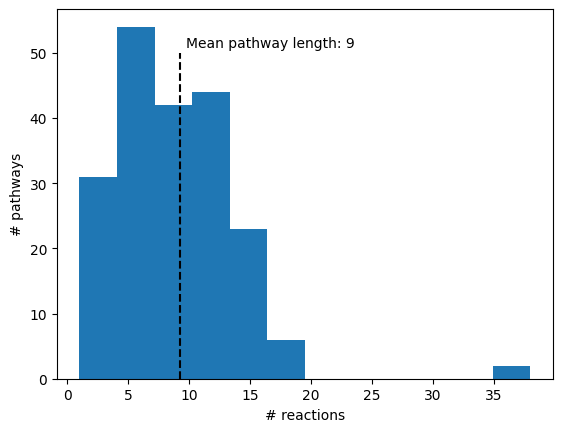

202


In [5]:
'''
Histogram of pathway length w/ average, SD
'''
pwy_len = []
for elt in pk_pwys:
    pwy_len.append(len(meta[elt].reaction_list))

pwy_len = np.array(pwy_len)
mean, var, tot = pwy_len.mean(), pwy_len.var(), len(pwy_len)

fig, ax = plt.subplots()
ax.hist(pwy_len, bins=12)
ax.set_xlabel('# reactions')
ax.set_ylabel('# pathways')
ax.vlines(mean, 0, 50, color='k', ls='--')
ax.text(mean * 1.05, 50 * 1.05, f"Mean pathway length: {mean:.0f}", ha='left', va='top')
plt.show()

print(tot)

In [6]:
'''
Fraction mapped
'''

map_frac = len(mapped_rxns) / len(all_rxns)
map_frac

0.1848101265822785

In [7]:
'''
Count repeat reactions
'''
starters = ['|PROPIONYL-COA|', '|MALONYL-COA|', '|ACETYL-COA|', '|METHYL-MALONYL-COA|', '|D-METHYL-MALONYL-COA|']
rxn_cts_dict = {}
for elt in pk_pwys:
    for this_rxn in meta[elt].reaction_list:
        # Filter out PKS reactions
        substrates = meta[this_rxn].substrates
        has_starters = len(set(substrates) & set(starters)) > 0

        if not has_starters:
            if this_rxn not in rxn_cts_dict:
                rxn_cts_dict[this_rxn] = 1
            else:
                rxn_cts_dict[this_rxn] += 1


rxn_cts = [[elt[1], elt[0]] for elt in sorted(zip(rxn_cts_dict.values(), rxn_cts_dict.keys()), reverse=True)]
did_map_repeat_ct = np.array([[int(elt[0] in mapped_rxns), elt[1]] for elt in rxn_cts])
map_frac_w_repeats = did_map_repeat_ct[did_map_repeat_ct[:,0].astype(bool), 1].sum() / did_map_repeat_ct[:, 1].sum()
map_frac_w_repeats


0.19053549190535493

In [8]:
'''
Tables of count-ordered coreactants x3
'''

f"{mapped_coreactants[0][1]}"

'H<sub>2</sub>O'

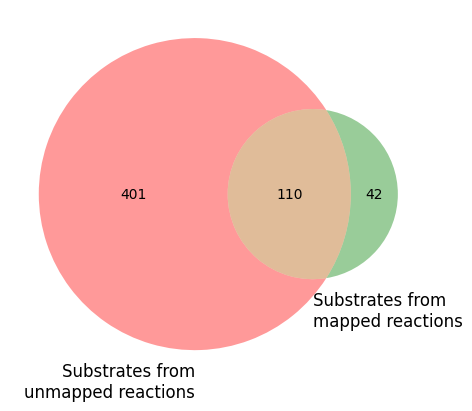

In [9]:
'''
Venn diagram mapped unmapped coreactants
'''

# Set operations
mapped_coreactants_set = set(mapped_coreactants[:,1])
unmapped_coreactants_set = set(unmapped_coreactants[:,1])
coreactants_intersection = mapped_coreactants_set & unmapped_coreactants_set
mapped_coreactants_only = mapped_coreactants_set - unmapped_coreactants_set
unmapped_coreactants_only = unmapped_coreactants_set - mapped_coreactants_set
venn_cts = len(unmapped_coreactants_only), len(mapped_coreactants_only), len(coreactants_intersection)

# Draw venn diagram
venn2(subsets=venn_cts, set_labels=('Substrates from\nunmapped reactions', 'Substrates from\nmapped reactions'))
plt.show()



In [19]:


n = 10
top_mapped_coreactants_only = get_n_top(n, mapped_coreactants_only, all_coreactants, 1, 2)
top_unmapped_coreactants_only = get_n_top(n, unmapped_coreactants_only, all_coreactants, 1, 2)

print(top_mapped_coreactants_only)
print(top_unmapped_coreactants_only)


[['geranyl diphosphate', 2], ['dihydrocurcumin', 2], ['7-hydroxylaurate', 2], ['20-deoxo-20-dihydrorosamicin', 2], ["2-((1R,3S),-1',9'-dihydroxy-1'-methyl-10'-oxo-3',4',5',10'-tetrahydro-1H-benzo[g]isochromen-3'-yl)acetate", 2], ['16-hydroxypalmitate', 2], ["(S)-4-(3'-acetyl-5'-hydroxy-4'-oxo-1',4'-dihydronapthalen-2'-yl)-3-hydroxybutanoate", 2], ['tetrahydrocurcumin', 1], ['streptovaricin G', 1], ['prenyl diphosphate', 1]]
[['<i>S</i>-adenosyl-L-methionine', 49], ['<i>S</i>-adenosyl-L-homocysteine', 47], ['CO<SUB>2</SUB>', 34], ['dTDP', 24], ['an acyl-[acp domain within a polyketide synthase]', 15], ['a soluble [acyl-carrier protein]', 13], ['UDP-&alpha;-D-glucose', 10], ['UDP', 10], ['dTDP-D-desosamine', 6], ['a malonyl-[BryP acyl-carrier protein]', 6]]


In [18]:
top_mapped_coreactants_only

[['geranyl diphosphate', 2],
 ['dihydrocurcumin', 2],
 ['7-hydroxylaurate', 2],
 ['20-deoxo-20-dihydrorosamicin', 2],
 ["2-((1R,3S),-1',9'-dihydroxy-1'-methyl-10'-oxo-3',4',5',10'-tetrahydro-1H-benzo[g]isochromen-3'-yl)acetate",
  2],
 ['16-hydroxypalmitate', 2],
 ["(S)-4-(3'-acetyl-5'-hydroxy-4'-oxo-1',4'-dihydronapthalen-2'-yl)-3-hydroxybutanoate",
  2],
 ['tetrahydrocurcumin', 1],
 ['streptovaricin G', 1],
 ['prenyl diphosphate', 1]]

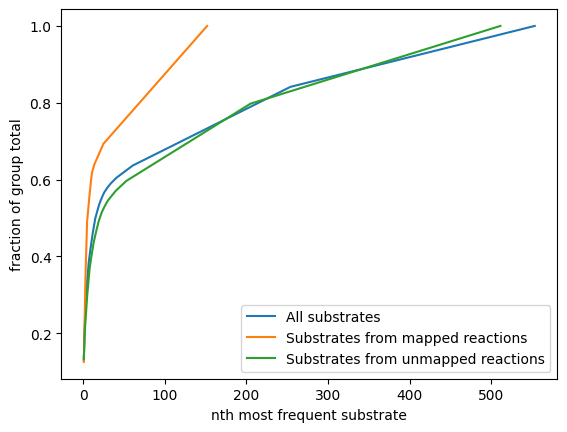

In [11]:
'''
CDFs of coreactants, 3 curves one plot
'''
labels = ['All substrates', 'Substrates from mapped reactions', 'Substrates from unmapped reactions']

fig, ax = plt.subplots()
for i, arr in enumerate([all_coreactants, mapped_coreactants, unmapped_coreactants]):
    cts = arr[:,-1].astype(int)
    tot = cts.sum()
    cdf = np.cumsum(cts) / tot
    x = np.arange(1, len(cdf) + 1)
    ax.plot(x, cdf, label=labels[i])

ax.set_xlabel('nth most frequent substrate')
ax.set_ylabel('fraction of group total')
ax.legend()
plt.show()

In [12]:
rxn = meta.rxn_11714
rxn.ec_number

['|EC-2.5.1.94|']

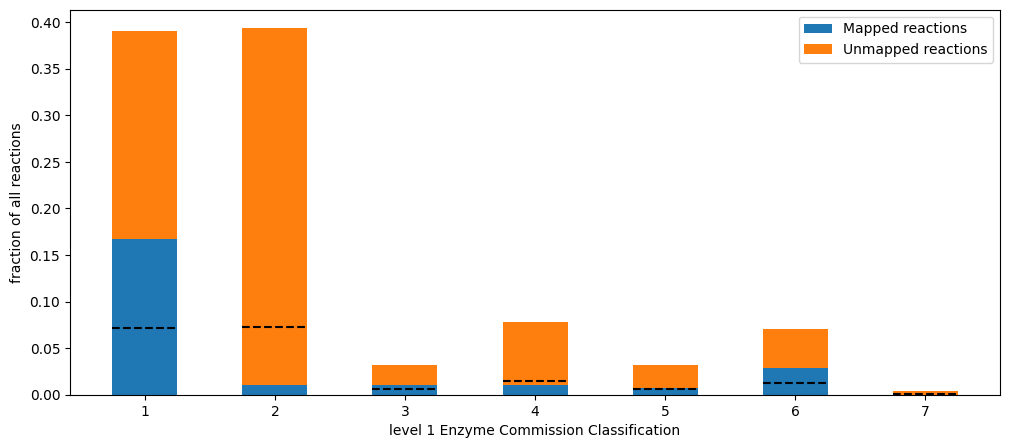

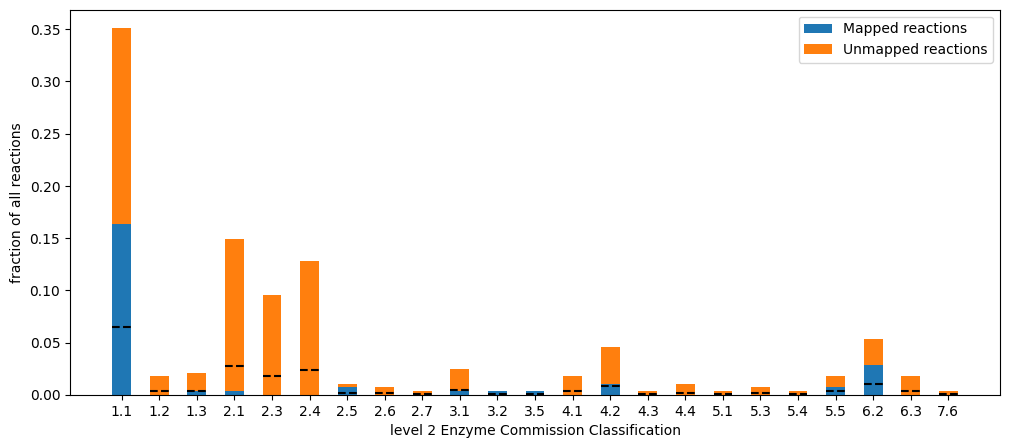

In [13]:
'''
Histogram of reaction ECC, 3 bars one plot (normalized to total count in each group)
'''
# Count eccs into dicts
ecc_arrs = [[{}, {}], [{}, {}], [{}, {}]]
for i, arr in enumerate([all_rxns, mapped_rxns, unmapped_rxns]):
    for elt in arr:
        try:
            this_ecc = meta[elt].ec_number
            if this_ecc is not None:
                this_ecc = this_ecc[0].lstrip('|EC-').rstrip('|')
                ecc1, ecc2 = this_ecc[0], this_ecc[:3]

                if ecc1 not in ecc_arrs[i][0]:
                    ecc_arrs[i][0][ecc1] = 1
                else:
                    ecc_arrs[i][0][ecc1] += 1

                if ecc2 not in ecc_arrs[i][1]:
                    ecc_arrs[i][1][ecc2] = 1
                else:
                    ecc_arrs[i][1][ecc2] += 1
        except:
            pass

# Get all eccs for both levels
ecc1_all_keys = []
ecc2_all_keys = []
for elt in ecc_arrs:
    ecc1_all_keys += list(elt[0].keys())
    ecc2_all_keys += list(elt[1].keys())

ecc1_all_keys = list(set(ecc1_all_keys))
ecc2_all_keys = list(set(ecc2_all_keys))

# Assign 0 where no ecc recorded
for elt in ecc_arrs:
    for k1 in ecc1_all_keys:
        if k1 not in elt[0]:
            elt[0][k1] = 0

    for k2 in ecc2_all_keys:
        if k2 not in elt[1]:
            elt[1][k2] = 0

# Make two plots
labels = ['All reactions', 'Mapped reactions', 'Unmapped reactions']
width = 0.5
for i in range(2): # Iterate over 2 levels of ecc
    fig, ax = plt.subplots(figsize=(12,5))
    xs = np.arange(len(ecc_arrs[0][i]))
    tot = sum(list(ecc_arrs[0][i].values()))
    

    for j in range(1,3): # Iterate over all, mapped, unmapped
        names = sorted(list(ecc_arrs[j][i].keys()))
        values = np.array([ecc_arrs[j][i][name] for name in names])
        values = values / tot

        if j == 1:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j])
            last_values = values
        else:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j], bottom=last_values)
        
    # Make chance lines
    for k, x in enumerate(xs):
        top = last_values[k] + values[k]
        ax.hlines(top * 0.185, x - width / 2, x + width / 2, color='k', ls='--')
    
    ax.set_xlabel(f"level {i + 1} Enzyme Commission Classification")
    ax.set_ylabel('fraction of all reactions')
    ax.legend()
    plt.show()



In [11]:
'''
Pull metacyc rxns for quan
'''
meta = pc.so('meta')
meta_rxns = meta.reactions
rxns = meta.get_frame_objects([elt.frameid for elt in meta_rxns])

In [20]:
# Pull all slots from reaction frame

keys = ['atom_mappings', 'common_name', 'ec_number', 'enzymatic_reaction', 'gibbs_0', 'in_pathway',
        'left', 'names', 'right', 'substrates', 'reaction_balance_status', 'reaction_direction']

rxn_dict = {}
for elt in rxns:
    rxn_dict[elt.frameid] = {}
    for k in keys:
        rxn_dict[elt.frameid][k] = elt[k]

In [12]:
# Pull all metacyc reactions smiles
# Pull all metacyc reaction_balance_status, reaction_direction

rxn_smiles_dict = {}
rxn_balance_direction = [['rxn_id', 'reaction_balance_status', 'reaction_direction']]
for elt in rxns:
    rxn_smiles_dict[elt.frameid] = []
    rxn_balance_direction.append([elt.frameid, elt.reaction_balance_status, elt.reaction_direction])
    
    left_dict = {}
    if elt.left is not None:
        for reactant in elt.left:
            try:
                left_dict[reactant] = meta[reactant].smiles
            except:
                left_dict[reactant] = ''

    right_dict = {}
    if elt.right is not None:
        for product in elt.right:
            try:
                right_dict[product] = meta[product].smiles
            except:
                right_dict[product] = ''

    rxn_smiles_dict[elt.frameid].append(left_dict)
    rxn_smiles_dict[elt.frameid].append(right_dict)

In [13]:
rxn_smiles_dict['|RXN-16531|'], rxn_balance_direction[1]

([{'|ACETYL-COA|': 'CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(OP([O-])(OC[C@@H]1([C@@H](OP([O-])([O-])=O)[C@@H](O)[C@@H](O1)N2(C3(\\N=C/N=C(C(\\N=C/2)=3)/N))))=O)([O-])=O',
   '|MALONYL-COA|': 'CC(C)([C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)[O-])COP(=O)(OP(=O)(OC[C@@H]1([C@@H](OP([O-])(=O)[O-])[C@@H](O)[C@@H](O1)N2(C3(\\N=C/N=C(C(\\N=C/2)=3)/N))))[O-])[O-]',
   '|ACP|': None,
   '|PROTON|': '[H+]'},
  {'|CPD-17794|': None,
   '|CO-A|': 'CC(C)(COP([O-])(=O)OP(OC[C@H]3(O[C@@H](N1(C2(\\N=C/N=C(C(\\N=C/1)=2)/N)))[C@H](O)[C@H](OP([O-])(=O)[O-])3))(=O)[O-])[C@@H](O)C(=O)NCCC(=O)NCCS',
   '|CARBON-DIOXIDE|': 'C(=O)=O',
   '|WATER|': 'O'}],
 ['|RXN-16531|', '|BALANCED|', '|LEFT-TO-RIGHT|'])

In [15]:
with open('metacyc_all_reactions_smiles_221214.json', 'w') as f:
    json.dump(rxn_smiles_dict, f)

In [18]:
with open('reaction_balance_direction_221214.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(rxn_balance_direction)


In [27]:
with open('metayc_all_reactions_221209.json', 'r') as f:
    loaded_dict = json.load(f)

In [29]:
len(loaded_dict)

19597